In [1]:
import matplotlib.pyplot as plt
import torch

from training import get_dataloaders, Trainer
from tracking import SamplingTracker2D, GridTracker2D
from flow import UnconditionalFlow
from simulator import Simulator
import visualisation
from visualisation import multiple_trajectory_plot, density_plot
torch.set_printoptions(precision=1)

# Track and Visualise Workflow

## Preliminary - simulator

A toy simulator for producing trajectories is defined in simulator.py. This is not critical for the rest of the application, but we need to get the data from somewhere. We van view a few paths from this simulator.

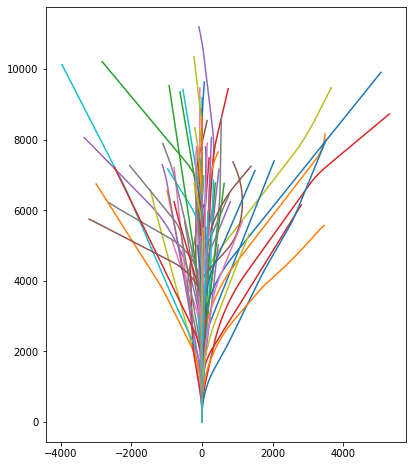

In [2]:
sim = Simulator()
trajectories = [sim()[-1] for _ in range(100)]
multiple_trajectory_plot(trajectories)

## Training

We instantiate the dataloaders and normalising flow. We need one batch from the dataloader for z-scoring, which is why there's a one-step loop.

In [3]:
train_loader, val_loader = get_dataloaders()
for i in train_loader:
    flow = UnconditionalFlow(i)
    break
trainer = Trainer(train_loader, val_loader, flow)

Perform the training.

In [4]:
trainer.train();

 epoch = 15, train loss = 2.674e-01, val loss = 1.686e+01, epochs since improvement = 6   

Visualise the samples in comparison to the dataset.

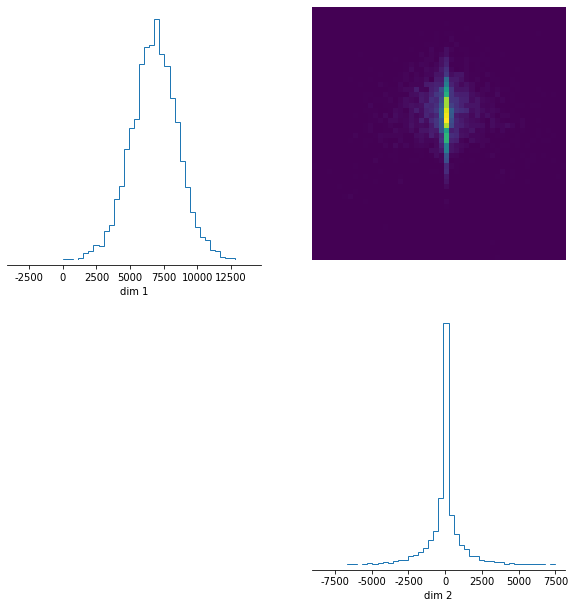

In [ ]:
density_plot(train_loader.dataset)

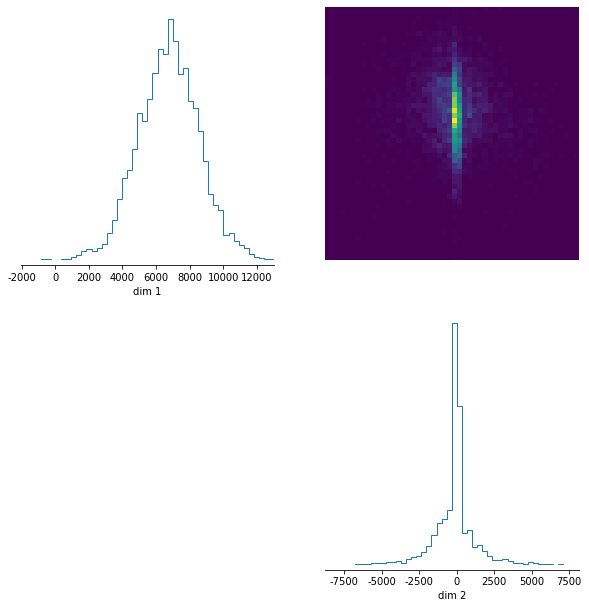

In [ ]:
samples = flow.sample(5000).detach()
density_plot(samples)

A visual inspection suggests that the learned distribution matches the simulated one well (though it is a touch more diffuse). Given how simple the distribution is, it is likely a mixture of Gaussians would be sufficient for fitting and much quicker - perhaps a little addition for later.

It would be interesting to write a more complex simulator, especially one with a multimodal density (e.g. by simulating an island which has to be avoided with rejection sampling).

## Tracking

Having a good estimator for the possible end points of the trajectories enables us to use these predictions to track an object. The bare-bones algorithm for this would be.
```
1. guess current position given last known location
2. check if object is present at guess - if yes, update last known location
3. repeat
```
In this section I simulate doing steps 1 and 2. This requires a procedure for choosing and ordering which positions to check.

### Sampling Tracker

We can randomly sample positions from the density estimator. I've implemented a basic - not especially efficient - version of this. There are two issues with the current implementation, which I expect would be easy to remedy with a bit more time investment:

1. The tracker does not search the whole space.
2. The scan areas overlap substantially, which is a waste of resources.

In [ ]:
# true_position = sim()[0] # if we want to generate a new one
samplingtracker = SamplingTracker2D(flow, 10)

Simulate tracking by assigning a position where the object is.

In [ ]:
true_position = torch.tensor([0, 6000])
checked, found = samplingtracker.simulate_tracking(true_position)
last_position_checked = checked[-1]
if found:
    print(f'found with scan centred at {last_position_checked} after {len(checked)} tries') 
else:
    print('not found')

found with scan centred at tensor([3.1e+00, 6.0e+03]) after 9425 tries


How often do we succeed? Unsurprisingly, it depends on the typicality of the true position. For the position defined earlier, most initialisations of the tracker succeed. 

In [ ]:
count_successes = 0
attempts = 10
for i in range(attempts):
    samplingtracker = SamplingTracker2D(flow, 10)
    _, found = samplingtracker.simulate_tracking(true_position)
    if found:
        count_successes+=1

print(f'found {count_successes}/{attempts} times')

found 10/10 times


But you could get very unlucky with a rare event.

In [ ]:
true_position_bad = torch.tensor([-4000, 4000])

count_successes = 0
attempts = 10
for i in range(attempts):
    samplingtracker = SamplingTracker2D(flow, 10)
    _, found = samplingtracker.simulate_tracking(true_position_bad)
    if found:
        count_successes+=1

print(f'found {count_successes}/{attempts} times')

found 0/10 times


## Grid Tracker

We can circumvent this failure problem by making to search a whole grid. The trick is then in how we order the points - fortunately, the density estimator allows as to determine the likelihood of any point in the region.

In [ ]:
gridtracker = GridTracker2D(flow,10)
checked, found = gridtracker.simulate_tracking(true_position)
last_position_checked = checked[-1]

if found:
    print(f'found with scan centred at {last_position_checked} after {len(checked)} tries') 
else:
    print('not found')

/mnt/c/Users/Sammy/OneDrive/Desktop/Code/TrajectoryFlow/tracking.py:81: UserWarning: not all points to check are in area of interest, some will be ignored
  warnings.warn("not all points to check are in area of interest, some will be ignored")


found with scan centred at tensor([2.8e+00, 6.0e+03]), after 614017 tries


## Some next steps

1. Create a hybridised scanning procedure which leverages the advantages of the sampling and grid trackers.
2. Adapt the simulator to take additional variables so that using conditional density estimators is advantageous.
3. Scanning is not instant. The conditional density estimators would ideally be time-dependent, updating the to include the time since the object was last seen.
4. Speculative: consider using an RNN to embed a trajectory history as a conditioner for conditional density estimation. Having such a history could be informative for some applications.